# Russian text cleanup and word vectors, v. 1.0

This is the Jupyter notebook for Quinn Dombrowski's final projects for the 2019 "Digital Humanities Across Borders" (DLCL 204) course at Stanford University. All the DLCL 204 course materials are [available on Github](https://github.com/quinnanya/dlcl204).

This notebook addresses a subset of the research questions in [Quinn's project proposal](https://github.com/quinnanya/dlcl204/blob/master/harry_potter_tanya_grotter_project_2019/project_proposal_harry_potter_tanya_grotter_2019.md), which focuses on using word vectors to look at differences between the worlds of "Harry Potter" (as translated into Russian) and "Tanya Grotter" (a Russian parody). The final poster is [available here](https://github.com/quinnanya/dlcl204/blob/master/harry_potter_tanya_grotter_project_2019/dombrowski_dlcl204poster_2019.pdf).

**Analysis and visualization**

If you don't want to clean up texts and run your own word vectors, you can just play with the analysis of the models I put together using this code by skipping ahead to section 4 of the notebook and loading a model. The models are available on Github, for [the Russian translation of the "Harry Potter" series](https://github.com/quinnanya/dlcl204/blob/master/harry_potter_tanya_grotter_project_2019/russian_harrypotter.model), the ["Tanya Grotter" series](https://github.com/quinnanya/dlcl204/blob/master/harry_potter_tanya_grotter_project_2019/tanyagrotter.model), and [both series combined](https://github.com/quinnanya/dlcl204/blob/master/harry_potter_tanya_grotter_project_2019/russian_harrypotter_tanyagrotter.model). I'm sharing the full models so you can continue to train them (e.g. on corpora of fanfic from the same universe) if you so desire.

## 1. Getting the source texts
This notebook assumes you've already acquired the Russian translations of the *Harry Potter* series, as well as the text of the *Tanya Grotter* series. The source texts used here were obtained in *fb2* format and converted to *txt* files using [Calibre](https://calibre-ebook.com/). 

Once converted into *txt* files, each file was manually cleaned to remove all text before *Глава 1* ('chapter 1', e.g. titles, translator's notes, etc.), except where there was a quote or other meaningful text immediately preceding it. This meaningful text was retained.

A copy of each file was then placed in a directory named *hptg_noparatext*, which is referenced in the second code block below. Replace the text between the single quotes (*/Users/qad/Documents/hptg_noparatext*) with the full path to the directory where you have put your files. 

## 2. Cleaning the source texts
While working on this project, I noticed that the word vector generation was treating words that were immediately followed by punctuation (i.e. without an intervening space) as different from the same words without the punctuation. Words with different variants in capitalization were likewise treated differently, as were words followed by a line break. The following code blocks clean up all the texts in the specified directory to lower-case all words, and remove punctuation, line breaks, and stray spaces.

Stopword removal is *not* part of this text cleaning workflow, though stopwords were a problem in my early experiments with the word vectors. This prompted me to look more closely at my first batch of source files, at which point I realized that I only had an excerpt from each text, rather than the full novels. Once I had the full novels, [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) seems to have done its job in filtering out the stopwords. If stopwords are causing problems, it might be a sign that you don't have enough text to meaningfully generate word vectors.

**Note**: the code for cleaning the source text *replaces* the previous version of the file. If something goes wrong, or if you want to run this workflow again, you should start with the original version of the file that you placed in the specified directory. Be sure to keep a copy of it somewhere else so you can get back to it.

Even if you don't need to clean your source texts, be sure to run the first code block to import modules that will be important for the word vector steps below.

### 2.1 Importing modules and setting up paths
Change the value of *sourcefiledirectory* to where you've put your source files, then run the code block below first, even if you want to move on immediately to the word vectors. It imports a number of modules you'll need later.

In [1]:
#os is used for things like changing directories and listing files
import os
#io is used for opening and writing files
import io
#itertools is used for some of the iterative code
from itertools import chain
#glob is used to find all the pathnames matching a specified pattern (here, all text files)
import glob


#This is the full path to the directory where you've stored the source texts
sourcefiledirectory = '/Users/qad/Documents/hp_noparatext'


#Changing the directory to where you've stored the source texts, so you can open them in later code blocks
os.chdir(sourcefiledirectory)

### 2.2 Lower-casing all text
The code below **replaces** your source files with versions where all characters are lower-case. Be sure you have a copy of the original version of your source file somewhere else in case you need to go back to it!

In [59]:
#Look through the directory you specified to find files that end in .txt.
for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #For each file that ends in .txt, open and read its contents into a string. Then make the characters lower-case.
        f = open(filename, 'r')
        text = f.read()
        lines = [text.lower()]

        #Create a new file with the same file name (i.e. replacing the original file) and write the lowercase lines
        #This method also automatically closes the file once it's done
        with open(filename, 'w') as out:
            out.writelines(lines)

### 2.3 Lemmatizing
Because Russian is a highly inflected language, and the word vector code doesn't treat words with different inflectional endings as the same word, you'll get better results if you lemmatize the text, which will give the word vector code more contexts to work with for each word. Be warned: if you look at the text after this step, it may remind you of a first-year Russian student who hasn't understood the concepts of conjugation of declension! (e.g. "шрам не болеть уже девятнадцать год. все быть хорошо.")

pymystem3 is a Python module for the Mystem Russian NLP library created by Yandex, the major Russian search engine. If you haven't previously installed the pymystem3 Python module, open a terminal window and run `pip install pymystem3` and wait for the installation to finish before proceeding.

Running this next code block can take some time. After you start to run it, be sure to wait until the asterisk is replaced by a number in _In \[*\]_ (next to the upper left corner of the code block), indicating that the process is complete, before you move on to the next step.

In [60]:
#Import Mystem module
from pymystem3 import Mystem
mystem = Mystem()

#If a file in the source directory ends in .txt
for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):

        #Open it and read it into a string
        f = open(filename, 'r')
        origtext = f.read()
        
        #Then use Mystem to lemmatize the string
        tokens = mystem.lemmatize(origtext)
        tokens = [token for token in tokens]
        
        #Join up all the lemmatized output
        processedtext = "".join(tokens)
    
        #Write it to a new file that replaces the old one
        with open(filename, 'w') as out:
            out.writelines(processedtext)

### 2.4 Removing line breaks
Line breaks get attached to the previous word, so this code adds a space to separate them.

In [61]:
# Look for files in the source directory that end in .txt
for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string. Find newline characters (\n) and put a space before and after.
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace("\n", " \n ")]

        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)

### 2.5 Cleaning up punctuation
You need to either remove punctuation attached to words, or separate it from the words with a space.

In [62]:
# This gets rid of ellipses. Sets of more than one period complicate further text processing.

for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string, and do the find-and-replace
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace("...", "")]
        
        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)

In [63]:
# This gets rid of sets of two periods (yes, there were some of those in the source files!)

for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string, and do the find-and-replace
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace("..", "")]
        
        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)

In [64]:
# This takes a period followed by a space, and puts a space before it as well.
# You don't want to just get rid of all periods because they're used in abbreviations.

for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string, and do the find-and-replace
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace(". ", " . ")]
        
        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)

In [65]:
# Sometimes the period is followed by a newline rather than a space, so this code puts a space before those.

for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string, and do the find-and-replace
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace(".\n", " .\n")]
        
        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)

In [66]:
# Gets rid of colons

for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string, and do the find-and-replace
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace(":", "")]
        
        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)

In [ ]:
# Gets rid of semicolons

for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string, and do the find-and-replace
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace(";", "")]
        
        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)

In [67]:
# Gets rid of commas

for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string, and do the find-and-replace
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace(",", "")]
        
        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)

In [68]:
# Gets rid of colons

for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string, and do the find-and-replace
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace(":", "")]
        
        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)

In [ ]:
# Gets rid of « quotation marks

for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string, and do the find-and-replace
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace("«", "")]
        
        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)

In [69]:
# Gets rid of » quotation marks

for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string, and do the find-and-replace
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace("»", "")]
        
        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)

In [71]:
# Replaces ellipsis characters

for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string, and do the find-and-replace
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace("…", "")]
        
        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)
        out.close()

### 2.6 Putting each sentence on its own line
One of the ways I was trying to process the text required each sentence to be on its own line. As part of the punctuation cleanup above, we've already inserted a newline character after periods (along with separating the period from the preceding word). The code below does the same for other ways to end a sentence.

In [70]:
# Replaces exclamation marks with a newline character

for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string, and do the find-and-replace
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace("!", " \n ")]

        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)
        out.close()

In [72]:
# Replaces quesiton marks with a newline character

for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        
        #Read each text file into a string, and do the find-and-replace
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace("?", " \n ")]

        #Write output to a new file with the same name as the original, overwriting the original file.
        with open(filename, 'w') as out:
            out.writelines(lines)
        out.close()

### 2.7 Removing multiple spaces

At this point, there are still places in the texts with five spaces (after previous chapter headers). This removes them and replaces them with a single space.

In [73]:
for filename in os.listdir(sourcefiledirectory):
    if filename.endswith(".txt"):
        f = open(filename, 'r')
        text = f.read()
        lines = [text.replace("     ", " ")]

        with open(filename, 'w') as out:
            out.writelines(lines)
        out.close()

## 3. Word vector creation

The code blocks in this section generate the word vector representation for a set of texts. You can specify a different directory than the one used for the data cleaning, which can be useful if you want to run the vectors separately for different subsets of your corpus (e.g. just "Harry Potter", just "Tanya Grotter", etc.) To do this, copy the cleaned up text files for the subset of the corpus that you want to run into a new directory, and put the path to that new directory in the first code block below for *vector_sources*.

Before you run this for the first time, you need to install the *gensim* Python package. Open a terminal window and type `pip install gensim`.

In [4]:
# gensim is a Python module for generating and analyzing word vectors
import gensim
# Logging allows you to watch the progress of long-running processes
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# word2vec is used to generate the vectors, phrases to identify phrases as an input for vector generation
from gensim.models import word2vec, Phrases
from gensim.models.phrases import Phraser
# These utilities are used for exporting and loading models
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import KeyedVectors

vector_sources="/Users/qad/Documents/megacorpus"

2019-03-18 09:01:12,140 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-03-18 09:01:12,141 : INFO : built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)


### 3.1 List each file and its length
This is a confirmation step that lists all the files that will be used as the input for the word vectors.

In [6]:
#Change directory to where the data for your word vectors is
os.chdir(vector_sources)
#List all the documents in the directory with the data for your word vectors
documents = list()
for filename in glob.glob("*.txt"):
    #Open each text file in the directory and read it into a string
    f = io.open(filename, mode="r", encoding="utf-8")
    filedata = f.read()
    #Print the filename along with how many characters (i.e. letters, numbers, etc.) are in the file
    print(filename + " = " + str(len(filedata)) + " chars")
    documents = documents + filedata.split("\n")

tg5_np.txt = 541160 chars
tg9_np.txt = 525558 chars
hp2_np.txt = 517700 chars
tg7_np.txt = 481492 chars
tg13_np.txt = 446259 chars
hp6_np.txt = 1055524 chars
tg3_np.txt = 448843 chars
tg1_np.txt = 488070 chars
hp4_np.txt = 1081564 chars
tg11_np.txt = 478490 chars
tg14_np.txt = 525765 chars
hp1_np.txt = 570991 chars
tg4_np.txt = 506129 chars
tg8_np.txt = 538395 chars
tg6_np.txt = 417821 chars
hp3_np.txt = 624201 chars
tg2_np.txt = 452976 chars
hp7_np.txt = 1200015 chars
tg12_np.txt = 496177 chars
tg10_np.txt = 434876 chars
hp5_np.txt = 1506670 chars


### 3.2 Identify phrases
This code block identifies bigram and trigram (2-word and 3-word, respectively) phrases. There's not a lot of this in the "Harry Potter" and "Tanya Grotter" corpora, with a few notable exceptions (e.g. Тетя Нинель), and especially if you have a small corpus, phrase mis-identification is possible through repeated words.

Phrases are treated like single words when doing the word vector generation.

**Note:** this will take some time, and will generate a lot of status messages in the process.

In [15]:
# Generates bigrams and trigrams from the text
sentence_stream = [doc.split(" ") for doc in documents]
trigram_sentences_project = []
bigram = Phraser(Phrases(sentence_stream))
trigram = Phraser(Phrases(bigram[sentence_stream]))

for sent in sentence_stream:
    bigrams_ = bigram[sent]
    trigrams_ = trigram[bigram[sent]]
    trigram_sentences_project.append(trigrams_)

2019-03-14 11:31:38,762 : INFO : collecting all words and their counts
2019-03-14 11:31:38,762 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-03-14 11:31:38,950 : INFO : PROGRESS: at sentence #10000, processed 125027 words and 71580 word types
2019-03-14 11:31:39,123 : INFO : PROGRESS: at sentence #20000, processed 244767 words and 122527 word types
2019-03-14 11:31:39,272 : INFO : PROGRESS: at sentence #30000, processed 343538 words and 153788 word types
2019-03-14 11:31:39,547 : INFO : PROGRESS: at sentence #40000, processed 466686 words and 197682 word types
2019-03-14 11:31:39,812 : INFO : PROGRESS: at sentence #50000, processed 583265 words and 235827 word types
2019-03-14 11:31:39,995 : INFO : PROGRESS: at sentence #60000, processed 693353 words and 263986 word types
2019-03-14 11:31:40,177 : INFO : PROGRESS: at sentence #70000, processed 813650 words and 296320 word types
2019-03-14 11:31:40,367 : INFO : PROGRESS: at sentence #80000, processed 942445 

### 3.3 Running and saving word vectors
This code block sets the parameters for vector generation, generates vectors, and saves the model.

The default parameters should work in most cases. If you change the *num_features*, you'll need to change it again in the visualization code below.

**Note:** this will take some time and generate a lot of status messages in the process.

In [16]:
# Sets values for various parameters for vector generation.
num_features = 200    # Word vector dimensionality                      
min_word_count = 2    # Minimum word count                        
num_workers = 20      # Number of threads to run in parallel
context = 5           # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words


# Sets up the code to run the word vector creation
model = word2vec.Word2Vec(trigram_sentences_project, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)


# Saves model; you can change the name as long as it ends in .model
model.save("word2vec.model")

2019-03-14 11:32:34,984 : INFO : collecting all words and their counts
2019-03-14 11:32:34,985 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-14 11:32:35,013 : INFO : PROGRESS: at sentence #10000, processed 90025 words, keeping 13235 word types
2019-03-14 11:32:35,047 : INFO : PROGRESS: at sentence #20000, processed 173955 words, keeping 18850 word types
2019-03-14 11:32:35,079 : INFO : PROGRESS: at sentence #30000, processed 232418 words, keeping 21727 word types
2019-03-14 11:32:35,123 : INFO : PROGRESS: at sentence #40000, processed 321430 words, keeping 25270 word types
2019-03-14 11:32:35,146 : INFO : PROGRESS: at sentence #50000, processed 402176 words, keeping 28024 word types
2019-03-14 11:32:35,168 : INFO : PROGRESS: at sentence #60000, processed 470962 words, keeping 29730 word types
2019-03-14 11:32:35,195 : INFO : PROGRESS: at sentence #70000, processed 551018 words, keeping 31431 word types
2019-03-14 11:32:35,225 : INFO : PROGRESS: at s

2019-03-14 11:32:41,075 : INFO : EPOCH 3 - PROGRESS: at 40.01% examples, 614355 words/s, in_qsize 40, out_qsize 0
2019-03-14 11:32:41,908 : INFO : worker thread finished; awaiting finish of 19 more threads
2019-03-14 11:32:41,917 : INFO : worker thread finished; awaiting finish of 18 more threads
2019-03-14 11:32:41,928 : INFO : worker thread finished; awaiting finish of 17 more threads
2019-03-14 11:32:41,966 : INFO : worker thread finished; awaiting finish of 16 more threads
2019-03-14 11:32:41,989 : INFO : worker thread finished; awaiting finish of 15 more threads
2019-03-14 11:32:42,010 : INFO : worker thread finished; awaiting finish of 14 more threads
2019-03-14 11:32:42,010 : INFO : worker thread finished; awaiting finish of 13 more threads
2019-03-14 11:32:42,012 : INFO : worker thread finished; awaiting finish of 12 more threads
2019-03-14 11:32:42,013 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-03-14 11:32:42,013 : INFO : worker thread finished; a

In [17]:
# Print the total number of items (including words, phrases, standalone punctuation, etc.) in the model's vocabulary

print(len(model.wv.vocab))

32963


## 4. Word vector analysis

The code blocks below allow you to pull up most-similar and most-dissimilar terms, and attempt analogies with the word vectors. (The "Harry Potter" and "Tanya Grotter" corpora-- even combined-- don't seem to be large enough to support meaningful analogies, but you may be able to train the models further on fanfic to get there.)

### 4a Using an existing model
If you don't want to create your own word vectors, you can use one of the models [in the 2019 DLCL 204 class Github repo](https://github.com/quinnanyadlcl204/harry_potter_tanya_grotter_project_2019). Download a model, put in the full path to it on your own computer below, and then run the code below.

**You only need to do this if you haven't generated your own word vectors below. Otherwise, skip the following code block!**

In [ ]:
# DO NOT run this if you've already created your own word vectors. This is ONLY for loading an existing model.
fname="/Users/qad/Documents/megacorpus/word2vec.model"
model = gensim.models.Word2Vec.load(fname)

### 4.1 Most similar terms
Put any word in the corpus between the quotes below to show the most similar words. You can change the value of *topn* to show more, or fewer, words.

Keep in mind that if you used the preprocessing steps, the text is all lower-case and lemmatized, so no capital letters or inflected forms or else it will throw an error about the word not being in the vocabulary.

In [20]:
w1 = "таня"
model.wv.most_similar (positive=w1,topn=30)

[('ванька', 0.877533495426178),
 ('ягун', 0.8689327239990234),
 ('глеб', 0.7863993644714355),
 ('дядя_герман', 0.7722936272621155),
 ('гробыня', 0.7587413787841797),
 ('гунь', 0.7370982766151428),
 ('пипа', 0.7313662767410278),
 ('контрабас', 0.7291733622550964),
 ('шурасик', 0.7224383354187012),
 ('гурия', 0.719814658164978),
 ('бейбарсов', 0.7184752225875854),
 ('гоярын', 0.7170850038528442),
 ('баба-ягун', 0.7127678990364075),
 ('бейбарс', 0.7042436003684998),
 ('танья', 0.7021228075027466),
 ('дурнев', 0.6974852085113525),
 ('поклеп', 0.6945477724075317),
 ('девочка', 0.6920005679130554),
 ('пуппер', 0.6831161975860596),
 ('тарарах', 0.6827908754348755),
 ('она', 0.6824731826782227),
 ('гломов', 0.6695045232772827),
 ('медузий', 0.6670525074005127),
 ('соловей', 0.6548832654953003),
 ('ягге', 0.6519553661346436),
 ('тетя_нинель', 0.6475212574005127),
 ('академик', 0.6457759141921997),
 ('жикин', 0.6456589102745056),
 ('сарданападывать', 0.6456108093261719),
 ('смычок', 0.6419142484

### 4.2 Most dissimilar terms
Put any word in the corpus between the quotes below to show the most **dissimilar** words (i.e. those words that are used in the most dissimilar ways to the one you've given the model). You can change the value of *topn* to show more, or fewer, words.

Keep in mind that if you used the preprocessing steps, the text is all lower-case and lemmatized, so no capital letters or inflected forms or else it will throw an error about the word not being in the vocabulary.

In [22]:
w1 = "таня"
model.wv.most_similar (negative=w1,topn=30)

[('следом;', 0.12774811685085297),
 ('авад', 0.09581764042377472),
 ('глава_1', 0.09531575441360474),
 ('глава_4', 0.09290379285812378),
 ('юла', 0.08017073571681976),
 ('кулачище', 0.07570109516382217),
 ('сближение', 0.07238410413265228),
 ('глава_15', 0.06805382668972015),
 ('глава_6', 0.06316107511520386),
 ('глава_12', 0.05512887239456177),
 ('глава_11', 0.047614872455596924),
 ('глава_3', 0.04699961841106415),
 ('упасть)', 0.04512118175625801),
 ('–_а-а-а_!', 0.03533820062875748),
 ('глава_20', 0.03400961309671402),
 ('глава_18', 0.031087592244148254),
 ('+++', 0.028188422322273254),
 ('слабовольный', 0.027995344251394272),
 ('глава_19', 0.02654018998146057),
 ('глава_7', 0.013617536053061485),
 ('выдвигать_из-под', 0.0062788985669612885),
 ('булстрод', -0.0038258135318756104),
 ('массировать', -0.004032277502119541),
 ('к', -0.0041935741901397705),
 ('глава_2', -0.004836609587073326),
 ('иванова', -0.005985412746667862),
 ('глава_10', -0.008609574288129807),
 ('ай-яя-яя', -0.010

### 4.3 Analogies
Without a larger corpus, the results of these analogies is very dissatisfying. The code below shows how to construct these analogies if you want to try them.

The analogy code takes three words as input. To render the analogy гарри:квиддич::таня:??? (one might imagine драконбол as a high probability answer), you would use the code below. Or, more abstractly, given *A:B::C:??*, the code would be: `positive=['A','C'],negative=['B']`

In [23]:
# гарри is to квиддич what таня is to...
model.wv.most_similar(positive=['гарри','таня'],negative=['квиддич'],topn=30)

[('ванька', 0.6109093427658081),
 ('потом', 0.5722019672393799),
 ('глеб', 0.5676916837692261),
 ('ягун', 0.5544528365135193),
 ('дядя_герман', 0.5448166728019714),
 ('она', 0.5382934808731079),
 ('девочка', 0.5367289781570435),
 ('успевать', 0.5309395790100098),
 ('бейбарс', 0.5272471904754639),
 ('умирать_от_ужас', 0.52186119556427),
 ('контрабас', 0.5100302696228027),
 ('внезапно', 0.5021620988845825),
 ('танья', 0.5020432472229004),
 ('и-ван', 0.49899357557296753),
 ('едва', 0.4929889440536499),
 ('он', 0.49186408519744873),
 ('ладонь', 0.4902215003967285),
 ('нога', 0.48709237575531006),
 ('палец', 0.4864916205406189),
 ('вновь', 0.4841882288455963),
 ('академик', 0.48225346207618713),
 ('гробыня', 0.4773552417755127),
 ('баба-ягун', 0.4711926281452179),
 ('взгляд', 0.47030824422836304),
 ('разобижать', 0.46756649017333984),
 ('пожатие', 0.45487159490585327),
 ('дурнев', 0.4545498788356781),
 ('шурасик', 0.45272189378738403),
 ('умышленно', 0.4527214467525482),
 ('останавливаться'

## 5. Visualization
The code below will generate two kinds of visualizations for the word vectors, by reducing the dimensionality of the vectors from 200 dimensions (or however many you specified when creating the vectors) down to 2.

For this to work, you need the most recent version of *matplotlib*; as of March 2019, you may need to open a terminal and run `conda uninstall matplotlib` then `conda install matplotlib` to update to the latest version, depending on when you installed Anaconda.

You also need to install the *sklearn* module. In the terminal: `pip install sklearn`.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### 5.1 Visualizing similar words
The code below will plot a given word, and the most similar words to it. You can increase or decrease the number of values displayed by changing the *topn* value for *close_words* (currently 30).

You can input the word you want to use as the basis for similar words in the second code block below.

Note: if you changed the number of features to something other than 200 when generating word vectors, you'll need to change the line `arr = np.empty((0,200), dtype='f')`, replacing 200 with the number of features you used.

In [33]:
## visualizing subset of vectors
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,200), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.most_similar (word, topn=30)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    
    
    
    
    plt.scatter(x_coords, y_coords)
    


    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

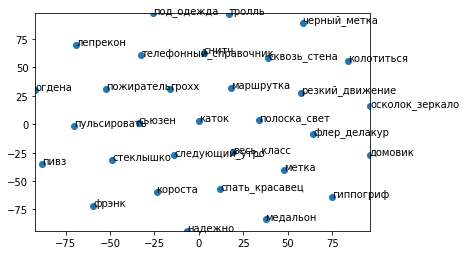

In [34]:
#put your word between the single quotes here
display_closestwords_tsnescatterplot(model,'снитч')

### 5.2 Visualizing all the words
To visualize the overall shape of all the word vectors, you can run the code below. You'll need to zoom in quite a bit to be able to make anything specific out of it. Certain traits (like a loop in the overall curve) may be warning signs of data cleaning issues.

In [36]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()
 
X = []
for word in model.wv.vocab:
    X.append(model.wv[word])
 
X = np.array(X)
print("Computed X: ", X.shape)
X_embedded = TSNE(n_components=2, n_iter=250, verbose=2).fit_transform(X)
print("Computed t-SNE", X_embedded.shape)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = X_embedded[:,0], X_embedded[:,1], model.wv.vocab
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="20pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=400, plot_height=400)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

Loading BokehJS ...

Computed X:  (32963, 200)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 32963 samples in 0.368s...
[t-SNE] Computed neighbors for 32963 samples in 310.388s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32963
[t-SNE] Computed conditional probabilities for sample 2000 / 32963
[t-SNE] Computed conditional probabilities for sample 3000 / 32963
[t-SNE] Computed conditional probabilities for sample 4000 / 32963
[t-SNE] Computed conditional probabilities for sample 5000 / 32963
[t-SNE] Computed conditional probabilities for sample 6000 / 32963
[t-SNE] Computed conditional probabilities for sample 7000 / 32963
[t-SNE] Computed conditional probabilities for sample 8000 / 32963
[t-SNE] Computed conditional probabilities for sample 9000 / 32963
[t-SNE] Computed conditional probabilities for sample 10000 / 32963
[t-SNE] Computed conditional probabilities for sample 11000 / 32963
[t-SNE] Computed conditional probabilities for sample 12000 / 32963
[t-SNE] Computed condi

## 6. Acknowledgements

Thanks to [Jeff Tharsen](http://tharsen.net/) for sharing a notebook that ran word vectors with gensim on Shakespeare. That notebook got this project off the ground by giving me an example of how to actually invoke the gensim phraser and word vector creation. The code in sections 3 and 4 is based off that notebook.

Thanks to Aneesha Bakharia for [this Medium post on *Using TSNE to Plot a Subset of Similar Words from Word2Vec*](https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229), where I found the code that section 5.1 is based on.

Thanks to Jeff Thompson for [this blog post on visualizing word vectors](https://www.jeffreythompson.org/blog/2017/02/13/using-word2vec-and-tsne/), which I reworked slightly for section 5.2.